<a href="https://colab.research.google.com/github/josephassiga/tensorflow-and-keras-tutorial/blob/main/W4/Lab5/W4_Lab_2_timeseries_conn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1D convelutional model





A temporal convnet could reuse the same representations across different days, much like a spatial convnet can reuse the same representations across different locations in an image.

The Conv1D layer relies on 1D windows that slide across input sequences, and the Conv3D layer relies on cubic windows that slide across input volumes

In [7]:
from tensorflow import keras
from tensorflow.keras import layers

In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2024-04-01 06:38:39--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.162.101, 52.217.106.126, 16.182.104.160, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.162.101|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  43.1MB/s    in 0.3s    

2024-04-01 06:38:40 (43.1 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


Now inspecting the data of the Jena weather dataset

In [2]:
import os

filename = os.path.join("jena_climate_2009_2016.csv")

with open(filename) as f:
  data = f.read()

# Retrieve all the content of the file.
lines = data.split("\n")
# Get the header of the file.
header = lines[0].split(",")
# Get other line execpt the header line.
lines = lines[1:]
print(f"Header : {header}")
print(f"Size of the file : {len(lines)}")
print(lines[0].split(",")[:])

Header : ['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
Size of the file : 420451
['01.01.2009 00:10:00', '996.52', '-8.02', '265.40', '-8.90', '93.30', '3.33', '3.11', '0.22', '1.94', '3.12', '1307.75', '1.03', '1.75', '152.30']


# Parsing the data

[ 9.96520e+02 -8.02000e+00  2.65400e+02 -8.90000e+00  9.33000e+01
  3.33000e+00  3.11000e+00  2.20000e-01  1.94000e+00  3.12000e+00
  1.30775e+03  1.03000e+00  1.75000e+00  1.52300e+02]


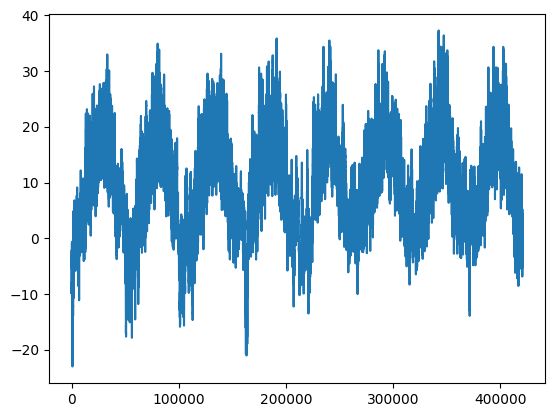

In [3]:
import numpy as np
from matplotlib import pyplot as plt

temperature = np.zeros(len(lines))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
  # For each line, i will only take data exacpt the Date Time
  values = [float(x) for x in line.split(",")[1:]]
  # We store column 1 in the temperature array
  temperature[i] = values[1]
  # We store all columns(including the temperature) in the raw_data
  raw_data[i,:] = values[:]

print(raw_data[0])
plt.plot(range(len(temperature)), temperature)

Computing the number of samples we’ll use for each data split

In [4]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


# Preparing the data
The exact formulation of the problem will be as follows: given data covering the previous five days and sampled once per hour, can we predict the temperature in 24 hours?

 First, let’s preprocess the data to a format a neural network can ingest. This is
easy: the data is already numerical, so you don’t need to do any vectorization. But
each timeseries in the data is on a different scale (for example, atmospheric pressure, measured in mbar, is around 1,000, while H2OC, measured in millimoles per
mole, is around 3). We’ll normalize each timeseries independently so that they all
take small values on a similar scale. We’re going to use the first 210,225 timesteps as
training data, so we’ll compute the mean and standard deviation only on this fraction of the data


In [5]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

Instantiating datasets for training, validation and testing

In [6]:
from tensorflow import keras

sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
 raw_data[:-delay],
 targets=temperature[delay:],
 sampling_rate=sampling_rate,
 sequence_length=sequence_length,
 shuffle=True,
 batch_size=batch_size,
 start_index=0,
 end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
 raw_data[:-delay],
 targets=temperature[delay:],
 sampling_rate=sampling_rate,
 sequence_length=sequence_length,
 shuffle=True,
 batch_size=batch_size,
 start_index=num_train_samples,
 end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
 raw_data[:-delay],
 targets=temperature[delay:],
 sampling_rate=sampling_rate,
 sequence_length=sequence_length,
 shuffle=True,
 batch_size=batch_size,
 start_index=num_train_samples + num_val_samples)

for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


Create a model with Sequencial API

In [10]:
model = keras.Sequential([
    #CNN
    keras.layers.Conv1D(8, 24, activation="relu", input_shape=(sequence_length, raw_data.shape[-1])),
    keras.layers.MaxPooling1D(2),
    keras.layers.Conv1D(8, 12, activation="relu"),
    keras.layers.MaxPooling1D(2),
    keras.layers.Conv1D(8, 6, activation="relu"),
    keras.layers.MaxPooling1D(2),

    #DNN
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dense(1)
])


model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 97, 8)             2696      
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 48, 8)             0         
 g1D)                                                            
                                                                 
 conv1d_4 (Conv1D)           (None, 37, 8)             776       
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 18, 8)             0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 13, 8)             392       
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 6, 8)              0

Create Model with Funcctional API

In [11]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 conv1d_6 (Conv1D)           (None, 97, 8)             2696      
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 48, 8)             0         
 g1D)                                                            
                                                                 
 conv1d_7 (Conv1D)           (None, 37, 8)             776       
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 18, 8)             0         
 g1D)                                                            
                                                                 
 conv1d_8 (Conv1D)           (None, 13, 8)             392 

Training and evaluating a densely connected model

In [12]:
callbacks = [
 keras.callbacks.ModelCheckpoint("jena_dense.keras",
 save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,
 epochs=10,
 validation_data=val_dataset,
 callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 84s 101ms/step - loss: 22.1990 - mae: 3.6984 - val_loss: 19.9014 - val_mae: 3.4961
Epoch 2/10
819/819 [==============================] - 88s 107ms/step - loss: 15.4935 - mae: 3.1342 - val_loss: 16.9505 - val_mae: 3.2628
Epoch 3/10
819/819 [==============================] - 88s 107ms/step - loss: 14.2305 - mae: 2.9934 - val_loss: 15.2976 - val_mae: 3.0960
Epoch 4/10
819/819 [==============================] - 87s 106ms/step - loss: 13.4676 - mae: 2.9065 - val_loss: 14.9463 - val_mae: 3.0674
Epoch 5/10
819/819 [==============================] - 88s 107ms/step - loss: 12.8589 - mae: 2.8371 - val_loss: 14.7141 - val_mae: 3.0450
Epoch 6/10
819/819 [==============================] - 89s 108ms/step - loss: 12.3429 - mae: 2.7751 - val_loss: 14.1978 - val_mae: 2.9762
Epoch 7/10
819/819 [==============================] - 87s 106ms/step - loss: 11.9494 - mae: 2.7287 - val_loss: 16.5099 - val_mae: 3.2268
Epoch 8/10
819/819 [=====================

Plotting results

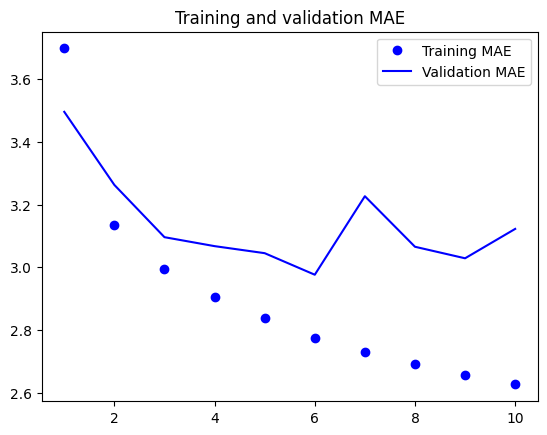

In [13]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()